In [1]:
import os
import gym
import numpy as np
# 仿真环境
os.environ['GYM_CONFIG_PATH'] = "emulation_config.py"
os.environ['GYM_CONFIG_CLASS'] = 'Train'
gym.logger.set_level(40)
import ppo_util

env_name = "CollisionAvoidance-v0"
env = ppo_util.create_env(env_name)

agents = ppo_util.generate_random_human_position(radius=0.3)
# agents = ppo_util.generate_human_position()
env.set_agents(agents)
obs = env.reset()
fov_obs = ppo_util.limit_distance_FOV(obs, FOV=180)

In [2]:
for _ in range(24):
    actions = {}
    actions[0] = 2
    obs, rewards, game_over, which_agents_done = env.step(actions)
    fov_obs = ppo_util.limit_distance_FOV(obs, FOV=180, distance=3)
    agents[0].step_num

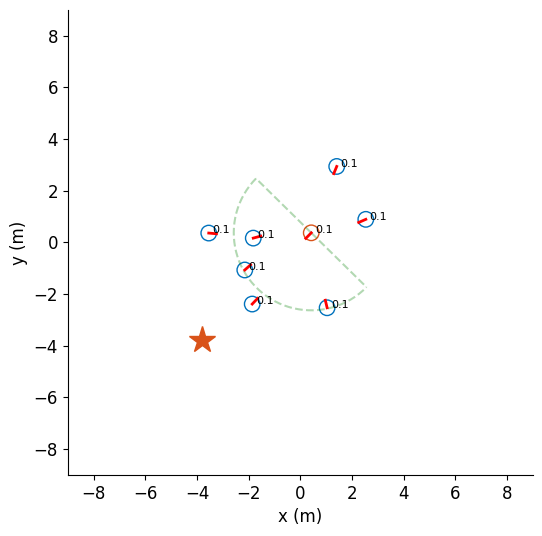

In [3]:
from visualize_plot import train_plot
train_plot(agents,fov=180)

In [30]:
import torch
s = fov_obs
num_agent = int(s[4])
robot_features = s[0:7]
robot_features = torch.tensor(robot_features, dtype=torch.float32)
robot_features = robot_features.unsqueeze(0)     # 扩充维度
human_features = []
# human_features = s[5:5+7]
# for i in range(5+7, num_agent*7, 7):
#     human_features = np.vstack((human_features, s[i:i+7]))
human_features = torch.tensor(human_features, dtype=float)
if human_features.numel():
    print("this tensor is not empty")
else:
    print("孔")
    
human_features.numel()

孔


0

In [12]:
print(s[0:30])
print(human_features)

[ 5.915  0.016  1.     0.3    3.     1.743 -1.429 -0.801  0.452  0.3
  0.6    1.654  2.842 -0.78  -0.584  0.028  0.3    0.6    2.348  1.598
  2.498 -0.227 -0.377  0.3    0.6    2.366  0.     0.     0.     0.   ]
[ 1.743 -1.429 -0.801  0.452  0.3    0.6    1.654]


In [ ]:
env1 = gym.make("CollisionAvoidance-v0")
env1.set_agents(agents)
obs1 = env1.reset()

In [ ]:
def states_to_graph(s):
    # 获取robot 的节点特征
    robot_features = s[0:4]
    # 获取agent的个数
    num_agent = int(s[4])
    # 边索引
    a = np.zeros(num_agent)
    b = np.linspace(1 ,num_agent, num_agent)
    a = np.append(a, b)
    edge_index = np.vstack((np.append(np.zeros(num_agent), np.linspace(1 ,num_agent, num_agent)),
                                np.append(np.linspace(1 ,num_agent, num_agent),np.zeros(num_agent))),
                        )
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    # 节点特征 
    node_feature = s[0:4]
    for i in range(5, num_agent*7, 7):
        node_feature = np.vstack((node_feature, s[i:i+4]))
    node_feature = torch.tensor(node_feature, dtype=torch.float)
    # 一张图的数据结构
    data = Data(x=node_feature, edge_index=edge_index)
    return data, robot_features

def batch_graph_data(s):
    # 变换维度
    s = s.reshape(-1, 68)
    # 存储批量图数据
    data_list = []
    robot_features_list = torch.zeros((s.shape[0], 4))
    for i in range(s.shape[0]):
        data, robot_features = states_to_graph(s[i])
        data_list.append(data)
        robot_features_list[i:] = robot_features 
    
    loader = DataLoader(dataset=data_list, batch_size=len(data_list), shuffle=False)
    batch = next(iter(loader))
    return batch, robot_features_list

In [ ]:
s = torch.tensor(obs, dtype=torch.float).unsqueeze(0)
a, b = batch_graph_data(s)

In [ ]:
one_states = s[0,0,:]
# 获取robot 的节点特征
robot_features = one_states[0:4]
# 获取agent的个数
num_agent = int(obs[4])
# 边索引
a = np.zeros(num_agent)
b = np.linspace(1 ,num_agent, num_agent)
a = np.append(a, b)
edge_index = np.vstack((np.append(np.zeros(num_agent), np.linspace(1 ,num_agent, num_agent)),
                             np.append(np.linspace(1 ,num_agent, num_agent),np.zeros(num_agent))),
                     )
edge_index = torch.tensor(edge_index, dtype=torch.long)
# 节点特征 
node_feature = one_states[0:4]
for i in range(5, num_agent*7, 7):
    node_feature = np.vstack((node_feature, one_states[i:i+4]))
node_feature = torch.tensor(node_feature, dtype=torch.float)

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch

# 组建数据
# 边索引
edge_index = torch.tensor([[0, 1],
                           [1, 0]], dtype=torch.long)
# 节点特征
x = torch.tensor([[-1,2,3,4], [0,1,2,3]], dtype=torch.float)
# 构建图
data1 = Data(x=x, edge_index=edge_index.t().contiguous())

In [ ]:
# 创建图结构数据
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
# 获取robot 的节点特征
obs = torch.tensor(obs, dtype=torch.float32)
robot_features = obs[0:4]
robot_features = torch.tensor(robot_features, dtype=torch.float)
print(robot_features)
# 获取agent的个数
num_agent = int(obs[4])
# 边索引
a = np.zeros(num_agent)
b = np.linspace(1 ,num_agent, num_agent)
a = np.append(a, b)
edge_index = np.vstack((np.append(np.zeros(num_agent), np.linspace(1 ,num_agent, num_agent)),
                             np.append(np.linspace(1 ,num_agent, num_agent),np.zeros(num_agent))),
                     )
edge_index = torch.tensor(edge_index, dtype=torch.long)
# 节点特征 
node_feature = obs[0:4]
for i in range(5, num_agent*7, 7):
    # node_feature.append(5+i,)
    node_feature = np.vstack((node_feature, obs[i:i+4]))
node_feature = torch.tensor(node_feature, dtype=torch.float)
# 一张图的数据结构
data = Data(x=node_feature, edge_index=edge_index)
data_list = [data, data1, data]
print(data)
loader = DataLoader(dataset=data_list, batch_size=3, shuffle=False)
print(next(iter(loader)))
# for step, a in enumerate(loader):
#     print(f"step:{step}, data:{a}")

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
# 可视化
g = to_networkx(a)
nx.draw(g, with_labels=g.nodes)

In [39]:
a = np.arange(1+1,2,1)
if a.size:
    print("bukong")
else:
    print("空")

TypeError: 'int' object is not callable

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# GAT Layer
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        # Xavier Initialization of Weights
        # W , a 学习参数
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # 激活函数：LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # 线性变换
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.input_features = 4                 # 输入特征维度
        self.hid = 16                           # 隐藏层的维度
        self.in_head = 6                        # 注意力头数
        self.output_features = 32               # 输出特征维度
        self.out_head = 1
        self.fc1_hidden = 64
        self.rnn_hidden_dim = 64
        self.action_dim = 13
        self.actor_rnn_hidden = None
        self.critic_rnn_hidden = None
        self.activate_func = nn.Tanh()

        # actor
        # GAT
        self.actor_conv1 = GATConv(self.input_features, self.hid, heads=self.in_head, dropout=0.6)
        self.actor_conv2 = GATConv(self.hid*self.in_head, self.output_features, concat=False,
                             heads=self.out_head, dropout=0.6)
        # GRU
        self.actor_fc1 = nn.Linear(self.output_features + 4 ,self.fc1_hidden)
        self.actor_rnn = nn.GRU(self.fc1_hidden, self.rnn_hidden_dim, batch_first=True)
        self.actor_fc2 = nn.Linear(self.rnn_hidden_dim, 13)

    def forward(self, data, robot_features):
        x, edge_index = data.x, data.edge_index
        # robot 节点索引
        robot_index = data.ptr[:-1]
        x = self.actor_conv1(x, edge_index) 
        # x = F.tanh(x)
        x = self.activate_func(x)
        x = self.actor_conv2(x, edge_index)
        # 提取 GAT 后 robot 的特征
        x = torch.index_select(x, 0, robot_index)
        # 拼接robot的特征
        x = torch.cat((x, robot_features),dim=1)
        # GRU
        x = self.actor_fc1(x)
        x = self.activate_func(x)
        x, self.actor_rnn_hidden = self.actor_rnn(x, self.actor_rnn_hidden)
        logit = self.actor_fc2(x)
        return logit

        
        # return F.log_softmax(x, dim=1)

In [2]:
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
from torch.distributions import Categorical

# 模拟数据：2*100*dim
s = np.zeros((2, 100, 110))
shape = s.shape
a = s.reshape(-1, shape[2])
# robot_features = s[:,:,0:4]
# human_features = s[:,:,5:int(s[:,:,4])*7+5]
# # dim = human_features.shape
# print(dim)



In [3]:
num_agent = 1
# a = np.zeros(num_agent)
# b = np.linspace(1 ,num_agent, num_agent)
# a = np.append(a, b)
edge_index = np.vstack((np.append(np.zeros(num_agent), np.linspace(1 ,num_agent, num_agent)),
                            np.append(np.linspace(1 ,num_agent, num_agent),np.zeros(num_agent))),
                    )
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [14]:
np.array([[0],[0]]).shape

(2, 1)

In [ ]:
# for i in range(2):
#     for j in range(100):
#         s[i,j,:] = env.reset()
# s = torch.tensor(s, dtype=torch.float)

# s = torch.tensor(env.reset(), dtype=torch.float)
# batch_graph, robot_features = batch_graph_data(s)
# print(s.shape)
# print(batch_graph)

# model = GAT()
# print(model)
# model.train()
# out = model(batch_graph, robot_features)
# print(out.shape)
# dist = Categorical(logits=out)
# a = dist.sample()
# a_logprob = dist.log_prob(a)
# print(a.item(),a_logprob.item())
out1 = out.reshape(2,-1,12)
print(out1.shape)

In [ ]:
import torch
n = torch.randn([6,4])
p = torch.ones(n.shape[0])
p = p.unsqueeze(1)
print(n)
print(p)
n = torch.cat((n,p),1)
print(n)


In [ ]:
# example
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
dataset = TUDataset('data/TUDataset', name = 'MUTAG')


print(dataset[0])

train_dataset = [dataset[0], dataset[0]]

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
batch = next(iter(train_loader))
print(batch)

In [ ]:
dataset.num_features

In [ ]:
obs[1]

In [ ]:
from gym_collision_avoidance.envs import Config
from gym_collision_avoidance.envs.wrappers import FlattenDictWrapper
env_one = FlattenDictWrapper(env, dict_keys=Config.STATES_IN_OBS)
obs_one = env_one.reset()

In [ ]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler, SequentialSampler
batch_size = 16
mini_batch_size = 2
for index in BatchSampler(SequentialSampler(range(batch_size)), mini_batch_size, False):
    print(index)



In [ ]:
b = buffer['s'][index]
b.shape

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
# 数据集
dataset = TUDataset(
    root='../data/ENZYMES',
    name='ENZYMES',
    use_node_attr=True,
)
# 建立数据集加载器
# 每次加载32个数据到内存中
loader = DataLoader(
    # 要加载的数据集
    dataset=dataset,
    # ENZYMES包含600个图
    # 每次加载32个
    batch_size=32,
    # 每次加入进来之后是否随机打乱数据（可以增加模型的泛化性）
    shuffle=True
)
for batch in loader:
    # print(batch)
    print(batch.num_graphs)